In [ ]:
asin2 0.826

# Imports e métodos necessários

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import pandas as pd 
import xml.etree.ElementTree as et 

from scipy.stats import pearsonr

def parse_xml(xml_file):
    """Parse xml to pandas dataframe."""
    xtree = et.parse(xml_file)
    xroot = xtree.getroot() 

    df_cols = ['id', 't', 'h', 'similarity']
    rows = []

    for node in xroot:
        id_ = node.attrib.get("id")
        similarity = node.attrib.get("similarity")
        t = node.find("t").text
        h = node.find("h").text

        rows.append({
            "id": id_,
            "t": t, 
            "h": h,
            "similarity": similarity
        })
    return pd.DataFrame(rows, columns=df_cols, dtype=float)

def eval_similarity(pairs_gold, pairs_sys):
    '''
    Evaluate the semantic similarity output of the system against a gold score. 
    Results are printed to stdout.
    '''
    
    gold_values = np.array(pairs_gold)
    sys_values = np.array(pairs_sys)
    pearson = pearsonr(gold_values, sys_values)[0]
    absolute_diff = gold_values - sys_values
    mse = (absolute_diff ** 2).mean()
    
    print()
    print('Similarity evaluation')
    print('Pearson\t\tMean Squared Error')
    print('-------\t\t------------------')
    print('{:7.3f}\t\t{:18.2f}'.format(pearson, mse))

In [3]:
!ls ../data/assin2

assin2-blind-test.xml  assin2-dev.xml  assin2-test.xml	assin2-train-only.xml


In [4]:
df_ptbr_train = parse_xml('../data/assin2/assin2-train-only.xml')
df_ptbr_dev = parse_xml('../data/assin2/assin2-dev.xml')
df_ptbr_test = parse_xml('../data/assin2/assin2-test.xml')

In [5]:
print(f'assin-ptbr-train: {df_ptbr_train.shape}')
print(f'assin-ptbr-dev: {df_ptbr_dev.shape}')
print(f'assin-ptbr-test: {df_ptbr_test.shape}')

assin-ptbr-train: (6500, 4)
assin-ptbr-dev: (500, 4)
assin-ptbr-test: (2448, 4)


In [6]:
df_ptbr_train.head()

,id,t,h,similarity
0,1.0,Uma criança risonha está segurando uma pistola...,Uma criança está segurando uma pistola de água,4.5
1,2.0,Os homens estão cuidadosamente colocando as ma...,Os homens estão colocando bagagens dentro do p...,4.5
2,3.0,Uma pessoa tem cabelo loiro e esvoaçante e est...,Um guitarrista tem cabelo loiro e esvoaçante,4.7
3,4.0,Batatas estão sendo fatiadas por um homem,O homem está fatiando a batata,4.7
4,5.0,Um caminhão está descendo rapidamente um morro,Um caminhão está rapidamente descendo o morro,4.9


# Testes

## BERT

In [7]:
from typing import Callable, List, Optional, Tuple

import pandas as pd
from sklearn.base import TransformerMixin, BaseEstimator
import torch


class BertTransformer(BaseEstimator, TransformerMixin):
    def __init__(
            self,
            bert_tokenizer,
            bert_model,
            max_length: int = 60,
            embedding_func: Optional[Callable[[torch.tensor], torch.tensor]] = None,
    ):
        self.tokenizer = bert_tokenizer
        self.model = bert_model
        self.model.eval()
        self.max_length = max_length
        self.embedding_func = embedding_func

        if self.embedding_func is None:
            self.embedding_func = lambda x: x[0][:, 0, :].squeeze()

    def _tokenize(self, text: str) -> Tuple[torch.tensor, torch.tensor]:
        # Tokenize the text with the provided tokenizer
        tokenized_text = self.tokenizer.encode_plus(text,
                                                    add_special_tokens=True,
                                                    max_length=self.max_length
                                                    )["input_ids"]

        # Create an attention mask telling BERT to use all words
        attention_mask = [1] * len(tokenized_text)

        # bert takes in a batch so we need to unsqueeze the rows
        return (
            torch.tensor(tokenized_text).unsqueeze(0),
            torch.tensor(attention_mask).unsqueeze(0),
        )

    def _tokenize_and_predict(self, text: str) -> torch.tensor:
        tokenized, attention_mask = self._tokenize(text)

        embeddings = self.model(tokenized, attention_mask)
        return self.embedding_func(embeddings)

    def transform(self, text: List[str]):
        if isinstance(text, pd.Series):
            text = text.tolist()

        with torch.no_grad():
            return torch.stack([self._tokenize_and_predict(string) for string in text])

    def fit(self, X, y=None):
        """No fitting necessary so we just return ourselves"""
        return self

### bert-base-portuguse-cased

In [8]:
from transformers import BertModel, BertTokenizer

pretrained_model = '../data/PyTorch checkpoint/bert-base-portuguese-cased_pytorch_checkpoint'
tokenizer = BertTokenizer.from_pretrained(pretrained_model)
bert_model = BertModel.from_pretrained(pretrained_model)

bert_transformer = BertTransformer(tokenizer, bert_model)

/opt/conda/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [9]:
t_embeddings = bert_transformer.transform(df_ptbr_test['t'].tolist())
h_embeddings = bert_transformer.transform(df_ptbr_test['h'].tolist())

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [10]:
from sklearn.metrics.pairwise import  cosine_similarity

similarities = [5.0 * cosine_similarity([t], [h])[0][0] for t, h in zip(t_embeddings.numpy(), h_embeddings.numpy())]

In [11]:
pairs_gold = df_ptbr_test['similarity'].tolist()
pairs_sys = similarities

In [12]:
eval_similarity(pairs_gold, pairs_sys)


Similarity evaluation
Pearson		Mean Squared Error
-------		------------------
  0.617		              1.78


In [13]:
from scipy.stats import spearmanr
print('Spearman correlation: {:7.3f}'.format(spearmanr(pairs_gold, pairs_sys)[0]))

Spearman correlation:   0.579


### bert-large-portuguese-cased

In [14]:
from transformers import BertModel, BertTokenizer

pretrained_model = '../data/PyTorch checkpoint/bert-large-portuguese-cased_pytorch_checkpoint'
tokenizer = BertTokenizer.from_pretrained(pretrained_model)
bert_model = BertModel.from_pretrained(pretrained_model)

bert_transformer = BertTransformer(tokenizer, bert_model)

In [15]:
t_embeddings = bert_transformer.transform(df_ptbr_test['t'].tolist())
h_embeddings = bert_transformer.transform(df_ptbr_test['h'].tolist())

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [16]:
from sklearn.metrics.pairwise import  cosine_similarity

similarities = [5.0 * cosine_similarity([t], [h])[0][0] for t, h in zip(t_embeddings.numpy(), h_embeddings.numpy())]

In [17]:
pairs_gold = df_ptbr_test['similarity'].tolist()
pairs_sys = similarities

In [18]:
eval_similarity(pairs_gold, pairs_sys)


Similarity evaluation
Pearson		Mean Squared Error
-------		------------------
  0.268		              2.49


In [19]:
from scipy.stats import spearmanr
print('Spearman correlation: {:7.3f}'.format(spearmanr(pairs_gold, pairs_sys)[0]))

Spearman correlation:   0.588


## Sentence-BERT

### bert-base-portuguese-cased

In [20]:
from sentence_transformers import models, SentenceTransformer
# Use BERT for mapping tokens to embeddings

pretrained_model = '../data/PyTorch checkpoint/bert-base-portuguese-cased_pytorch_checkpoint'
word_embedding_model = models.Transformer(pretrained_model)

# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [21]:
t_embeddings = model.encode(df_ptbr_test['t'].tolist())
h_embeddings = model.encode(df_ptbr_test['h'].tolist())

In [22]:
from sklearn.metrics.pairwise import  cosine_similarity

similarities = [5.0 * cosine_similarity([t], [h])[0][0] for t, h in zip(t_embeddings, h_embeddings)]

In [23]:
pairs_gold = df_ptbr_test['similarity'].tolist()
pairs_sys = similarities

In [24]:
eval_similarity(pairs_gold, pairs_sys)


Similarity evaluation
Pearson		Mean Squared Error
-------		------------------
  0.676		              1.24


In [25]:
from scipy.stats import spearmanr
print('Spearman correlation: {:7.3f}'.format(spearmanr(pairs_gold, pairs_sys)[0]))

Spearman correlation:   0.621


### bert-large-portuguese-cased

<AxesSubplot:>

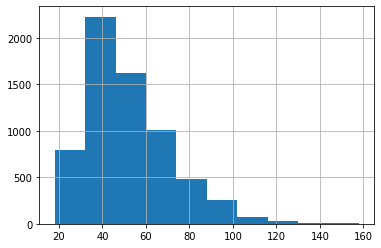

In [8]:
df_ptbr_train['t'].apply(len).hist()

In [18]:
from sentence_transformers import models, SentenceTransformer
# Use BERT for mapping tokens to embeddings

pretrained_model = '../data/PyTorch checkpoint/bert-large-portuguese-cased_pytorch_checkpoint'
word_embedding_model = models.Transformer(pretrained_model, max_seq_length=64)

# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

model = SentenceTransformer(modules=[word_embedding_model, pooling_model], device='cpu')

In [21]:
t_embeddings = model.encode(df_ptbr_test['t'].tolist(), show_progress_bar=True)
h_embeddings = model.encode(df_ptbr_test['h'].tolist(), show_progress_bar=True)

In [22]:
from sklearn.metrics.pairwise import  cosine_similarity

similarities = [5.0 * cosine_similarity([t], [h])[0][0] for t, h in zip(t_embeddings, h_embeddings)]

In [23]:
pairs_gold = df_ptbr_test['similarity'].tolist()
pairs_sys = similarities

In [24]:
eval_similarity(pairs_gold, pairs_sys)


Similarity evaluation
Pearson		Mean Squared Error
-------		------------------
  0.709		              1.92


In [31]:
from scipy.stats import spearmanr
print('Spearman correlation: {:7.3f}'.format(spearmanr(pairs_gold, pairs_sys)[0]))

Spearman correlation:   0.650


In [41]:
model = SentenceTransformer('xlm-r-distilroberta-base-paraphrase-v1')

In [48]:
import torch
t_embeddings = model.encode(['vodka', 'toddy', 'melancia', 'melancia', 'slova', 'espatula', 'tabua'], show_progress_bar=True)
h_embeddings = model.encode(['slova', 'achocolatado', 'melancia', 'melao', 'skyy', 'oleo', 'bandeja'], show_progress_bar=True)

RuntimeError: CUDA error: an illegal memory access was encountered

In [47]:
torch.Tensor(['vodka', 'toddy', 'melancia', 'melancia', 'slova', 'espatula', 'tabua'], dtype=torch.s)

AttributeError: module 'torch' has no attribute 'str'

In [35]:
[cosine_similarity([t], [h])[0][0] for t, h in zip(t_embeddings, h_embeddings)]

[0.5817832, 0.4695363, 0.99999994, 0.8385476, 0.7397175, 0.8074517, 0.6255622]

In [28]:
[cosine_similarity([t], [h])[0][0] for t, h in zip(t_embeddings, h_embeddings)]

[0.6169488, 0.6506598, 0.9999999, 0.59066564, 0.75980294]

# Fine-tuning Sentence-BERT

https://www.sbert.net/docs/training/overview.html

https://github.com/UKPLab/sentence-transformers/blob/master/examples/training/sts/training_stsbenchmark_continue_training.py

## bert-base-portuguese-cased

In [32]:
"""
This example loads the pre-trained SentenceTransformer model 'bert-base-nli-mean-tokens' from the server.
It then fine-tunes this model for some epochs on the STS benchmark dataset.
Note: In this example, you must specify a SentenceTransformer model.
If you want to fine-tune a huggingface/transformers model like bert-base-uncased, see training_nli.py and training_stsbenchmark.py
"""
from torch.utils.data import DataLoader
import math
from sentence_transformers import SentenceTransformer,  SentencesDataset, LoggingHandler, losses, util, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from datetime import datetime
import os
import csv
from sentence_transformers import models, SentenceTransformer



# Read the dataset
model_name = '/mnt/data/PyTorch checkpoint/bert-base-portuguese-cased_pytorch_checkpoint'
train_batch_size = 16
num_epochs = 4
model_save_path = '/mnt/data/sbert_base_finetuning_assin2'# + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")



# Load a pre-trained sentence transformer model
#model = SentenceTransformer(model_name)

word_embedding_model = models.Transformer(model_name)

# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

train_samples = []
dev_samples = []
test_samples = []

for i, row in df_ptbr_train.iterrows():
    inp_example = InputExample(texts=[row['t'], row['h']], label=row['similarity'] / 5)
    train_samples.append(inp_example)
    
for i, row in df_ptbr_dev.iterrows():
    inp_example = InputExample(texts=[row['t'], row['h']], label=row['similarity'] / 5)
    dev_samples.append(inp_example)
    
for i, row in df_ptbr_test.iterrows():
    inp_example = InputExample(texts=[row['t'], row['h']], label=row['similarity'] / 5)
    test_samples.append(inp_example)
    


train_dataset = SentencesDataset(train_samples, model)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)
train_loss = losses.CosineSimilarityLoss(model=model)


evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, name='sts-dev')


# Configure the training. We skip evaluation in this example
warmup_steps = math.ceil(len(train_dataset) * num_epochs / train_batch_size * 0.1) #10% of train data for warm-up


# Train the model
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=1000,
          warmup_steps=warmup_steps,
          output_path=model_save_path)


##############################################################################
#
# Load the stored model and evaluate its performance on STS benchmark dataset
#
##############################################################################

model = SentenceTransformer(model_save_path)
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_samples, name='sts-test')
test_evaluator(model, output_path=model_save_path)

0.7979499878718879

In [33]:
t_embeddings = model.encode(df_ptbr_test['t'].tolist(), show_progress_bar=True)
h_embeddings = model.encode(df_ptbr_test['h'].tolist(), show_progress_bar=True)

In [34]:
from sklearn.metrics.pairwise import  cosine_similarity

similarities = [5.0 * cosine_similarity([t], [h])[0][0] for t, h in zip(t_embeddings, h_embeddings)]

In [35]:
pairs_gold = df_ptbr_test['similarity'].tolist()
pairs_sys = similarities

In [36]:
eval_similarity(pairs_gold, pairs_sys)


Similarity evaluation
Pearson		Mean Squared Error
-------		------------------
  0.829		              0.52


In [38]:
from scipy.stats import spearmanr
print('Spearman correlation: {:7.3f}'.format(spearmanr(pairs_gold, pairs_sys)[0]))

Spearman correlation:   0.798


## bert-large-portuguese-cased

In [37]:
"""
This example loads the pre-trained SentenceTransformer model 'bert-base-nli-mean-tokens' from the server.
It then fine-tunes this model for some epochs on the STS benchmark dataset.
Note: In this example, you must specify a SentenceTransformer model.
If you want to fine-tune a huggingface/transformers model like bert-base-uncased, see training_nli.py and training_stsbenchmark.py
"""
from torch.utils.data import DataLoader
import math
from sentence_transformers import SentenceTransformer,  SentencesDataset, LoggingHandler, losses, util, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from datetime import datetime
import os
import csv
from sentence_transformers import models, SentenceTransformer



# Read the dataset
model_name = 'neuralmind/bert-large-portuguese-cased'
train_batch_size = 16
num_epochs = 4
model_save_path = '/mnt/data/sbert_finetuning_assin2'# + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")



# Load a pre-trained sentence transformer model
#model = SentenceTransformer(model_name)

word_embedding_model = models.Transformer(model_name, max_seq_length=16)

# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

train_samples = []
dev_samples = []
test_samples = []

for i, row in df_ptbr_train.iterrows():
    inp_example = InputExample(texts=[row['t'], row['h']], label=row['similarity'] / 5)
    train_samples.append(inp_example)
    
for i, row in df_ptbr_dev.iterrows():
    inp_example = InputExample(texts=[row['t'], row['h']], label=row['similarity'] / 5)
    dev_samples.append(inp_example)
    
for i, row in df_ptbr_test.iterrows():
    inp_example = InputExample(texts=[row['t'], row['h']], label=row['similarity'] / 5)
    test_samples.append(inp_example)
    


train_dataset = SentencesDataset(train_samples, model)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)
train_loss = losses.CosineSimilarityLoss(model=model)


evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, name='sts-dev')


# Configure the training. We skip evaluation in this example
warmup_steps = math.ceil(len(train_dataset) * num_epochs / train_batch_size * 0.1) #10% of train data for warm-up


# Train the model
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=1000,
          warmup_steps=warmup_steps,
          output_path=model_save_path)


##############################################################################
#
# Load the stored model and evaluate its performance on STS benchmark dataset
#
##############################################################################

model = SentenceTransformer(model_save_path)
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_samples, name='sts-test')
test_evaluator(model, output_path=model_save_path)

RuntimeError: CUDA error: an illegal memory access was encountered

In [40]:
t_embeddings = model.encode(df_ptbr_test['t'].tolist(), show_progress_bar=True)
h_embeddings = model.encode(df_ptbr_test['h'].tolist(), show_progress_bar=True)

In [41]:
from sklearn.metrics.pairwise import  cosine_similarity

similarities = [5.0 * cosine_similarity([t], [h])[0][0] for t, h in zip(t_embeddings, h_embeddings)]

In [42]:
pairs_gold = df_ptbr_test['similarity'].tolist()
pairs_sys = similarities

In [43]:
eval_similarity(pairs_gold, pairs_sys)


Similarity evaluation
Pearson		Mean Squared Error
-------		------------------
  0.834		              0.53


In [44]:
from scipy.stats import spearmanr
print('Spearman correlation: {:7.3f}'.format(spearmanr(pairs_gold, pairs_sys)[0]))

Spearman correlation:   0.805
